In [ ]:
# reference https://towardsdatascience.com/audio-deep-learning-made-simple-automatic-speech-recognition-asr-how-it-works-716cfce4c706

In [ ]:
import torchaudio
import matplotlib.pyplot as plt

# training_dataset = torchaudio.datasets.LIBRISPEECH("./", url='train-clean-100', download=True)
training_dataset = torchaudio.datasets.LIBRISPEECH("./", url='test-clean', download=True)
testing_dataset = torchaudio.datasets.LIBRISPEECH("./", url='test-clean', download=True)


100%|██████████| 331M/331M [00:12<00:00, 26.7MB/s]


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

# device = 'cuda' if torch.cuda.is_available else 'cpu'
device = 'cpu'
device

'cpu'

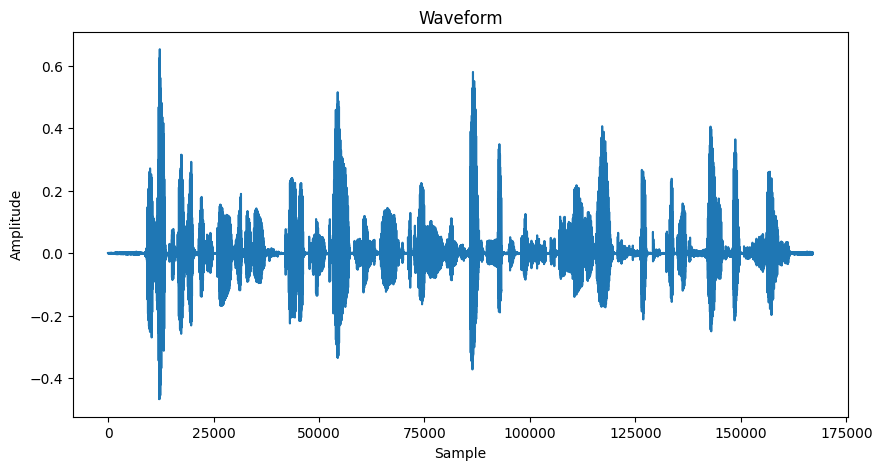

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


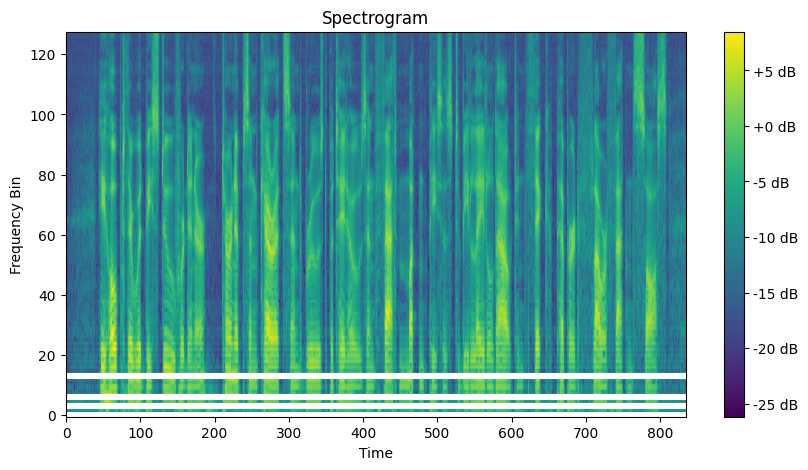

In [ ]:


# Load a sample from the training dataset
waveform, sample_rate, utterance_text, speaker_id, chapter_id, utterance_id = training_dataset[0]

# Plot the waveform
plt.figure(figsize=(10, 5))
plt.plot(waveform.t().numpy())
plt.title('Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

# Compute and plot the spectrogram
specgram = torchaudio.transforms.MelSpectrogram()(waveform)
plt.figure(figsize=(10, 5))
plt.imshow(specgram.log2()[0, :, :].numpy(), aspect='auto', origin='lower')
plt.title('Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency Bin')
plt.colorbar(format='%+2.0f dB')
plt.show()


In [ ]:
print(len(training_dataset))
print(len(testing_dataset))

print("""Basic Statistics for trainingdata0:
Mean Amplitude: 0.0004339974548202008
Std Deviation of Amplitude: 0.023022936657071114
Min Amplitude: -0.2608642578125
Max Amplitude: 0.279296875
Duration of Audio: 14.085 seconds""")

2620
2620
Basic Statistics for trainingdata0:
Mean Amplitude: 0.0004339974548202008
Std Deviation of Amplitude: 0.023022936657071114
Min Amplitude: -0.2608642578125
Max Amplitude: 0.279296875
Duration of Audio: 14.085 seconds


In [ ]:
char_map_str = """
 ' 0
 <SPACE> 1
 a 2
 b 3
 c 4
 d 5
 e 6
 f 7
 g 8
 h 9
 i 10
 j 11
 k 12
 l 13
 m 14
 n 15
 o 16
 p 17
 q 18
 r 19
 s 20
 t 21
 u 22
 v 23
 w 24
 x 25
 y 26
 z 27
 28
 """

In [ ]:

class TextTransform:
    """Maps characters to integers and vice versa"""
    def __init__(self):
        self.char_map_str = char_map_str
        self.char_map = {}
        self.index_map = {}
        for line in char_map_str.strip().split('\n'):
            try:
              ch, index = line.split()
            except:
              ch, index = ['', '0']
            self.char_map[ch] = int(index)
            self.index_map[int(index)] = ch

    def text_to_int(self, text):
        """ Use a character map and convert text to an integer sequence """
        int_sequence = []

        for c in text:

            if c == ' ':
                ch = self.char_map['']
            else:
                ch = self.char_map[c]
            int_sequence.append(ch)
        return int_sequence

    def int_to_text(self, labels):
        """ Use a character map and convert integer labels to an text sequence """
        string = []
        for i in labels:
            string.append(self.index_map[i])
        return ''.join(string).replace('', ' ')

In [ ]:
train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
    torchaudio.transforms.TimeMasking(time_mask_param=35)
)

test_audio_transforms = torchaudio.transforms.MelSpectrogram()

In [ ]:
text_transform = TextTransform()

In [ ]:
def data_processing(data, data_type="train"):
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []

    for (waveform, _, utterance, _, _, _) in data:

        if data_type == 'train':
            spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        else:
            spec = test_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        spectrograms.append(spec)
        label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
        labels.append(label)
        input_lengths.append(spec.shape[0]//4)
        label_lengths.append(len(label))

    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms, labels, input_lengths, label_lengths

In [ ]:
sample = [training_dataset[2]]
data_processing(sample)[0].shape

torch.Size([1, 1, 128, 531])

In [ ]:
train_loader = DataLoader(dataset=training_dataset,
                                batch_size=32,
                                shuffle=True,
                                collate_fn=lambda x: data_processing(x, 'train'),
                                )
test_loader = DataLoader(dataset=testing_dataset,
                            batch_size=32,
                            shuffle=False,
                            collate_fn=lambda x: data_processing(x, 'valid'),
                            )

In [ ]:
class SpeechRecognition(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
        self.lstm = nn.LSTM(32 * 64, 128, num_layers=2, batch_first=True)
        self.fc = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        # return x
        x = self.relu1(x)
        x = self.pool1(x)
        # return x -> [batch, 32, 64, width/2->(78)]
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)

        x = x.transpose(1, 2) # batch, time->(78), features->(2048)

        x, _ = self.lstm(x)
        return x
        x = self.fc(x)
        return x


In [ ]:
n_classes=29
model = SpeechRecognition(n_classes).to(device)
criterion = nn.CTCLoss(blank=28)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)


In [ ]:
# \mathbf{W_{out} = \frac{W_{in} - K + 2P} + 1}
# \mathbf{H_{out} = \frac{H_{in} - K + 2P} + 1}

# h_new -> 128

# 32, 64

In [ ]:
print(device)
temp = torch.rand(2, 1, 128, 156).contiguous().to(device) # _> batch, n_channels->constant, img_height ->constant, img_length


model(temp).shape


cpu


torch.Size([2, 78, 128])

In [ ]:
model(temp)

tensor([[[-0.0102,  0.0042,  0.0097,  ...,  0.0100,  0.0497,  0.0305],
         [-0.0226,  0.0131,  0.0208,  ...,  0.0213,  0.0831,  0.0563],
         [-0.0352,  0.0116,  0.0150,  ...,  0.0288,  0.1047,  0.0769],
         ...,
         [-0.0462,  0.0365, -0.0113,  ...,  0.0367,  0.1215,  0.0929],
         [-0.0506,  0.0306, -0.0223,  ...,  0.0446,  0.1259,  0.0991],
         [-0.0592,  0.0372, -0.0092,  ...,  0.0487,  0.1326,  0.0971]],

        [[-0.0246,  0.0008,  0.0189,  ..., -0.0048,  0.0469,  0.0207],
         [-0.0361,  0.0074,  0.0183,  ..., -0.0019,  0.0787,  0.0484],
         [-0.0446,  0.0043,  0.0064,  ...,  0.0140,  0.0942,  0.0609],
         ...,
         [-0.0591,  0.0264,  0.0166,  ...,  0.0365,  0.1243,  0.0940],
         [-0.0443,  0.0212,  0.0194,  ...,  0.0198,  0.1243,  0.0956],
         [-0.0341,  0.0211,  0.0189,  ...,  0.0164,  0.1132,  0.0966]]],
       grad_fn=<TransposeBackward0>)


two issues:
1. outputs coming out tensor of nans
2. when model is on cuda, the shape is giving error

In [ ]:
num_epochs = 2

torch.manual_seed(42)
model.train()
for epoch in range(num_epochs):
    for batch_idx, (spectrograms, labels, input_lengths, label_lengths) in enumerate(train_loader):
        optimizer.zero_grad()
        # print('input length', len(input_lengths), input_lengths)
        # print('label length', len(label_lengths), label_lengths)
        # print('spectrogram shape', spectrograms.shape)
        outputs = model(spectrograms)
        outputs = F.log_softmax(outputs, dim=2)
        outputs = outputs.transpose(0, 1)
        # print('output shape', outputs.shape)
        # print('labels shape', labels.shape)
        # print('inputlength', input_lengths)
        # print('label lengths', label_lengths)
        # input_lengths = torch.tensor([output.shape[0] for output in outputs])

        loss = criterion(outputs, labels, input_lengths, label_lengths)
        loss.backward()
        optimizer.step()
        if (batch_idx + 1) % 20 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, batch_idx+1, len(train_loader), loss.item()))


In [ ]:
outputs